In [1]:
import pypulse as pyp
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np
import pandas as pd
import glob

import sys

## 820-band

In [14]:
band = "820_band_meerguard_pazr"
clustered_data = pd.read_pickle(f"./results/pol_calibrated/{band}/0.0_sigma/Kmeans/7_kmeans_clusters.pkl")
clustered_results = pd.read_pickle(f"./results/pol_calibrated/{band}/0.0_sigma/Kmeans/7_clusters/7_clusters_results.plk")
unnormalized_data = pd.read_pickle(f"./results/pol_calibrated/{band}/0.0_sigma/unnormalized_data.pkl")

In [69]:
def clean_artifacts(cluster_average_pulse, clean_window, delta:int = 20):
    
    interpolating_bins = np.r_[clean_window[0]-delta : clean_window[0] , clean_window[1]+1: clean_window[1]+1 + delta]
    
    cluster_average_pulse[clean_window[0]:clean_window[1]+1] = np.interp(x=np.arange(clean_window[0], clean_window[1]+1, 1),
                                                                         xp=interpolating_bins, fp=cluster_average_pulse[interpolating_bins])
    
    opw = np.arange(50, 100)
    noise_rms = np.std(cluster_average_pulse[opw])
    noise = np.random.normal(0.0, noise_rms, size=clean_window[1]-clean_window[0]+1)
    cluster_average_pulse[clean_window[0]:clean_window[1]+1] += noise

    return cluster_average_pulse

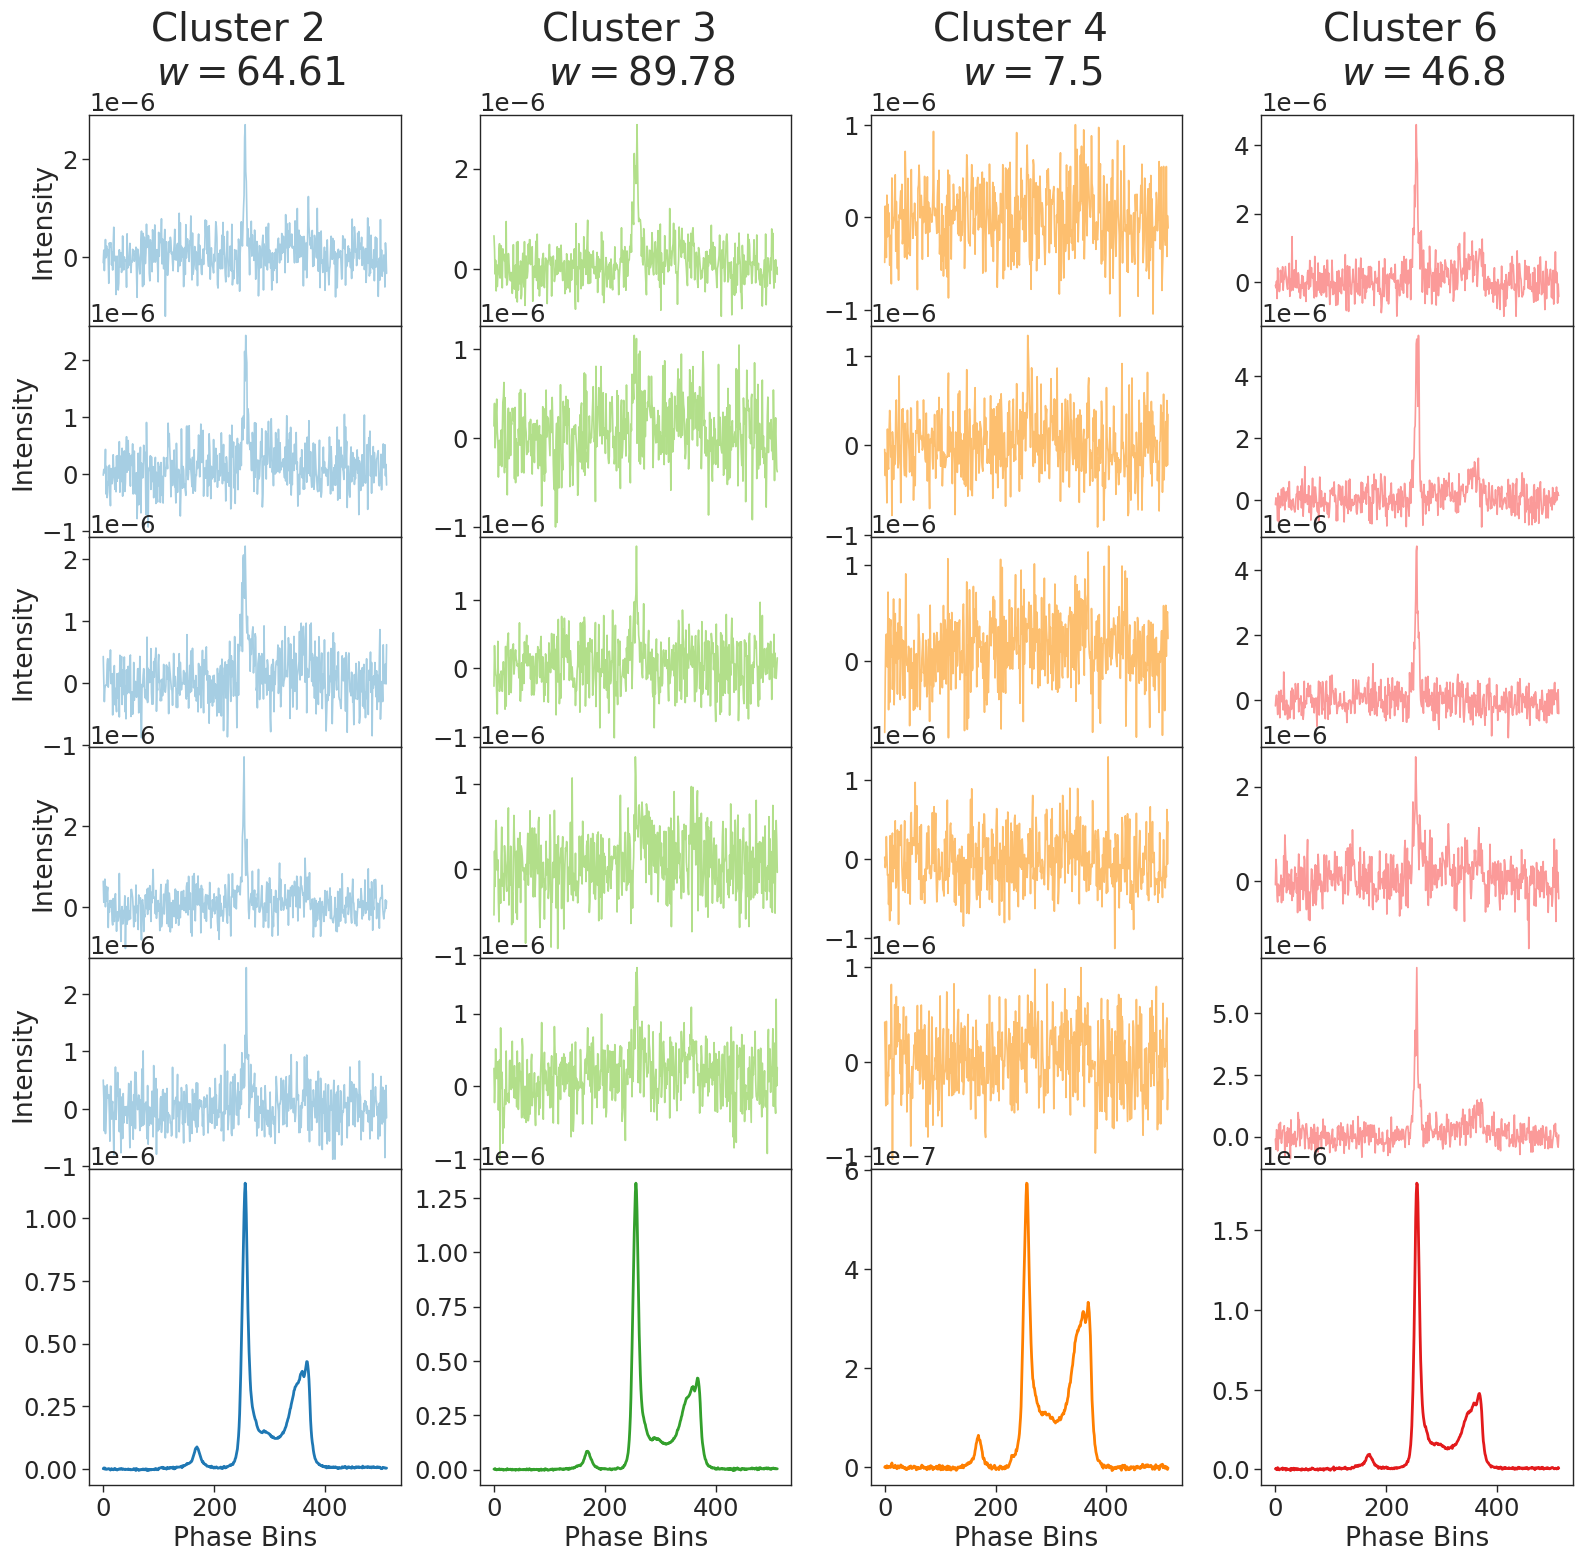

In [17]:
clusters : int = len(clustered_data.Cluster.unique())
bins = np.arange(1, 513, 1, dtype=int)

fig, axs = plt.subplots(nrows=6, ncols=4, sharex=True, figsize=(16, 16),
                        gridspec_kw=dict(hspace=0.0, height_ratios=[1, 1, 1, 1, 1, 1.5]))

sns.set_style('ticks')
sns.set_context("paper", font_scale = 2.0)
#cmap = sns.color_palette('colorblind')
cmap =  sns.color_palette(palette='Paired')[0:4] + sns.color_palette(palette='Paired')[6:8] + sns.color_palette(palette='Paired')[4:6]

#fig.suptitle(f'K-means with $k={n_clusters}$ clusters', fontsize=32)

for column, cluster_index in enumerate([2, 3, 4, 6]):
    
     # Isolate the single pulses in the cluster
    cluster_sp_times = clustered_data[clustered_data['Cluster'] == str(cluster_index)].index.to_numpy()
    cluster_average_pulse = np.average(unnormalized_data.loc[cluster_sp_times].to_numpy(), axis=0)
#    cluster_avg_sp = pyp.SinglePulse(cluster_average_pulse, opw=np.arange(0, 100))
#    cluster_avg_sp.remove_baseline(save=True)
     
    for row, sp_t in enumerate(cluster_sp_times[1:7]):
        
        if row == 0:
            axs[row, column].set_title(f'Cluster {cluster_index} \n $w={round(clustered_results["1/sigma^2"].iloc[cluster_index], 2)}$', fontsize=28)

        if row == 5:
            smoothed_cluster = clean_artifacts(cluster_average_pulse, [224, 227])
            axs[row, column].plot(smoothed_cluster, lw=2.0, color=cmap[2 * column + 1])
            axs[row, column].set_xlabel("Phase Bins")
            
        else:
            axs[row, column].plot(unnormalized_data.loc[[sp_t]].transpose().to_numpy(), color=cmap[2 * column])
             
            if column == 0:
                axs[row, column].set_ylabel("Intensity")

plt.tight_layout()
#plt.savefig("./plots/820_band_clusters_examples.pdf")
plt.show()

## L-band

In [33]:
band: str = "L_band_everything"
n_clusters: int = 5
clustered_data = pd.read_pickle(f"./results/pol_calibrated/{band}/0.0_sigma/Kmeans/{n_clusters}_kmeans_clusters.pkl")
#clustered_results = pd.read_pickle(f"./results/pol_calibrated/{band}/0.0_sigma/Kmeans/{n_clusters}_clusters/{n_clusters}_clusters_results.pkl")
unnormalized_data = pd.read_pickle(f"./results/pol_calibrated/{band}/0.0_sigma/unnormalized_data.pkl")

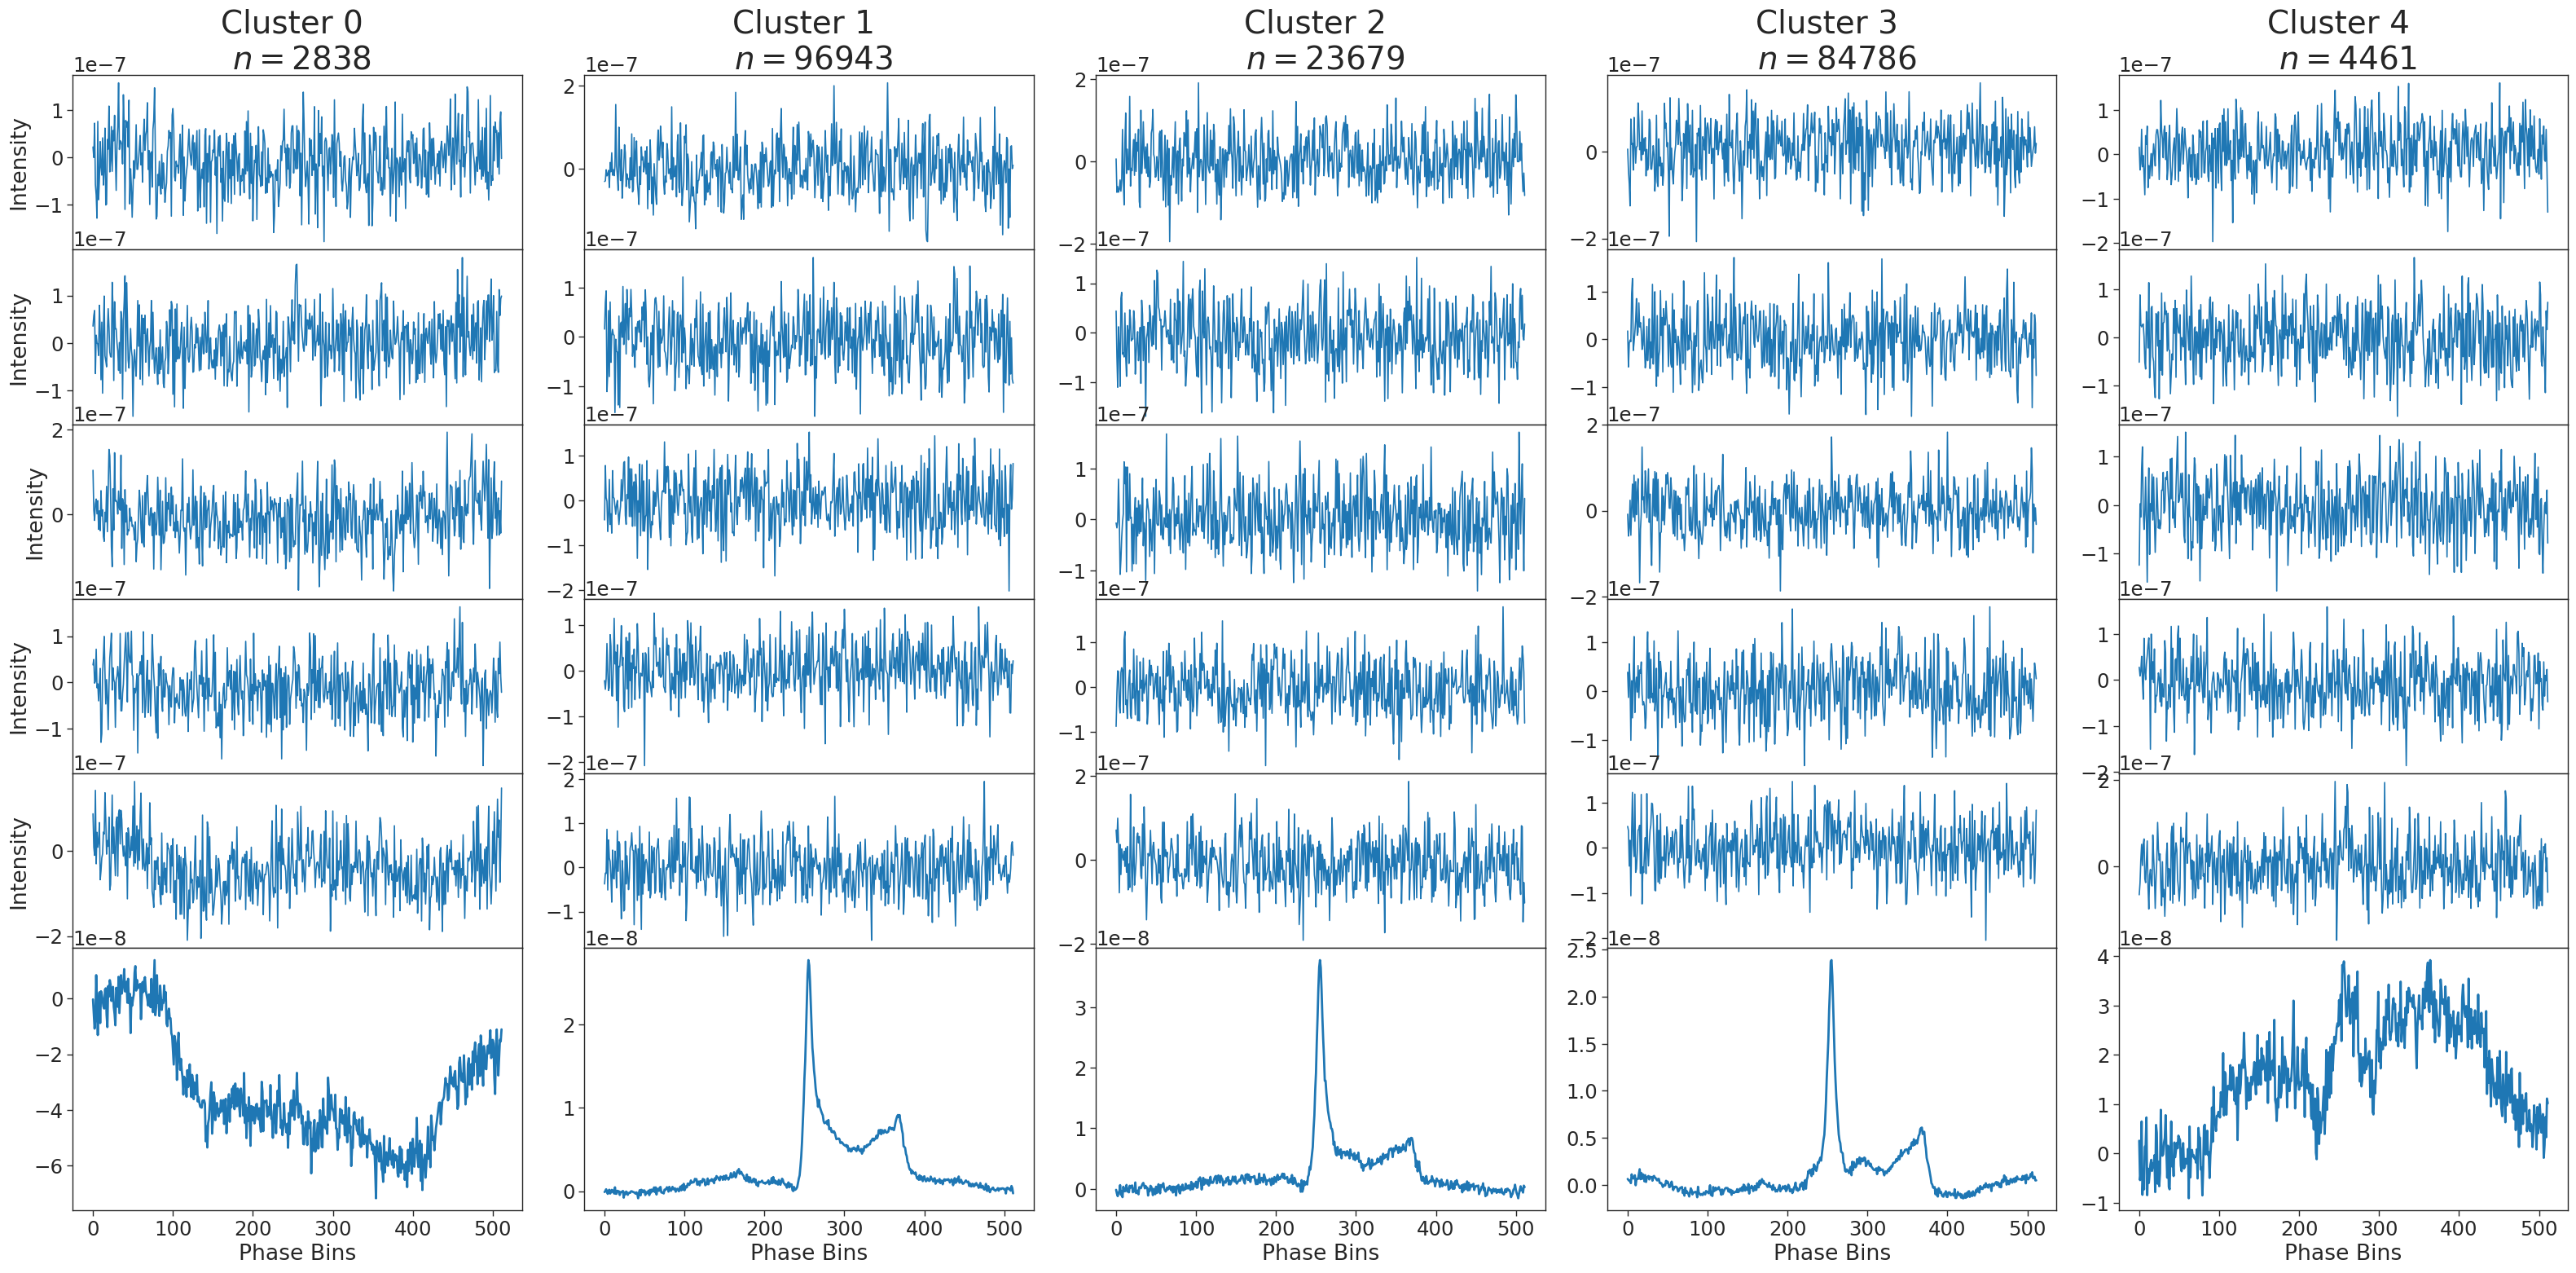

In [71]:
#n_clusters : int = len(clustered_data.Cluster.unique())
bins = np.arange(1, 513, 1, dtype=int)

fig, axs = plt.subplots(nrows=6, ncols=n_clusters, sharex=True, figsize=(32, 16),
                        gridspec_kw=dict(hspace=0.0, height_ratios=[1, 1, 1, 1, 1, 1.5]))

sns.set_style('ticks')
sns.set_context("paper", font_scale = 2.0)
cmap = sns.color_palette()
#cmap =  sns.color_palette(palette='Paired')[0:4] + sns.color_palette(palette='Paired')[6:8] + sns.color_palette(palette='Paired')[4:6]

#fig.suptitle(f'K-means with $k={n_clusters}$ clusters', fontsize=32)

for column, cluster_index in enumerate(range(n_clusters)):
    
     # Isolate the single pulses in the cluster
    cluster_sp_times = clustered_data[clustered_data['Cluster'] == str(cluster_index)].index.to_numpy()
    cluster_average_pulse = np.average(unnormalized_data.loc[cluster_sp_times].to_numpy(), axis=0)
#    cluster_avg_sp = pyp.SinglePulse(cluster_average_pulse, opw=np.arange(0, 100))
#    cluster_avg_sp.remove_baseline(save=True)
     
    for row, sp_t in enumerate(cluster_sp_times[1:7]):
        
        if row == 0:
            axs[row, column].set_title(f'Cluster {cluster_index} \n $n={len(cluster_sp_times)}$', fontsize=28)

        if row == 5:
            smoothed_cluster = clean_artifacts(cluster_average_pulse, [222, 238])
            smoothed_cluster = clean_artifacts(cluster_average_pulse, [275, 295])
#            smoothed_cluster = cluster_average_pulse
            axs[row, column].plot(smoothed_cluster, lw=2.0) #, color=cmap[2 * column + 1])
            axs[row, column].set_xlabel("Phase Bins")
            
        else:
            axs[row, column].plot(unnormalized_data.loc[[sp_t]].transpose().to_numpy()) #, color=cmap[2 * column])
             
            if column == 0:
                axs[row, column].set_ylabel("Intensity")

plt.tight_layout()
#plt.savefig("./plots/L_band_clusters_examples.pdf")
plt.show()